### Imports

In [1]:
%matplotlib notebook  
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
from pathlib import Path

# importing model and loss function
from model.kde_loss_Ba import Loss
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model

# importing training utility functions
#from model.training_kde import select_gpu, Results, trainNet
from functions.new_training_kde import select_gpu, Results, trainNet
from model.plots import dual_train_plots, replace_in_ax
from model.collectdata_kde_Ellipsoids import collect_t2kde_data
from functions.utils import vector_to_state_dict

# importing modified optimizers
from functions.new_optimizers import Adam, reversible_Adam, EpochEVE 

# plotting model output
from functions.plotting_DDplus_hists import load_data, plot_DDplus_hists

# shows GPU usage
!nvidia-smi

Mon Sep 20 00:44:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 36%   51C    P2    28W / 250W |   3735MiB / 12066MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

### Set up training parameters

In [2]:
# the output folder the results are stored in 
name   = 'example'

# note that baileyds is a symbolic link to a directory on share/lazy/
folder = 'baileyds/DDplus/' + name
output = Path(folder)
output.mkdir(exist_ok=True)

n_epochs = 15
batch_size = 16 
learning_rate = 1e-4
# choose gpu to use (or cpu)
device = "cuda:0"

In [3]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)
# my entry 
from functions.utils import get_param_state
param_states = []

### Load data

In [4]:

## Training dataset. You can put as many files here as desired.

train_loader = collect_t2kde_data('/share/lazy/will/data/June30_2020_80k_1.h5', 
                                #'/share/lazy/will/data/June30_2020_80k_2.h5',
                                #'/share/lazy/will/data/June30_2020_80k_3.h5',
                                #'/share/lazy/will/data/June30_2020_80k_4.h5',
                                batch_size=batch_size,
                                #device=device, #(only use with a small dataset, otherwise overloads GPU memory)
                                #slice = slice(None,60000) #for using a subset of a training set
                                )
                            
# Validation dataset
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                                batch_size=batch_size,
                                #device=device,
                                #slice = slice(18000,None)
                                )


Loading data...
pocaMx.shape =  (80000,)
nEvts =  80000
len(pocaMx[0]) =  199
len(pocaMx[1]) =  25
len(pocaMx[2]) =  369
len(pocaMx[3]) =  143
len(pocaMx[4]) =  160
majorAxis.shape =  (80000, 3)
minorAxis_1.shape =  (80000, 3)
minorAxis_2.shape =  (80000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 199
 iEvt, nTrks =  1 25
 iEvt, nTrks =  2 369
 iEvt, nTrks =  3 143
 iEvt, nTrks =  4 160
 iEvt, nTrks =  5 260
 iEvt, nTrks =  6 237
 iEvt, nTrks =  7 327
 iEvt, nTrks =  8 178
 iEvt, nTrks =  9 106
A.shape =  (80000,)
majorAxis[iTrk][0][0] =  0.00045611936
majorAxis[iTrk][1][0] =  -4.8292455e-05
majorAxis[iTrk][2][0] =  0.090019904
minorAxis_1[iTrk][0][0] =  -1.8602173
minorAxis_1[iTrk][1][0] =  -17.569641
minorAxis_1[iTrk][2][0] =  4.7891795e-08
minorAxis_2[iTrk][0][0] =  -17.569414
minorAxis_2[iTrk][1][0] =  1.8601931
minorAxis_2[iTrk][2][0] =  0.0900199
  
majorAxis[iTrk][0][0] =  0.002360258
majorAxis[iTrk][1][0] =  -0.007426616
majorAxis[iTrk][2][

len(X) =  20000
len(Xlist) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 37.36 s
outer loop X.shape =  (20000, 9, 600)
Constructing 20000 event dataset took 0.1482 s
x_t.shape =  torch.Size([20000, 9, 600])
x_t.shape[0] =  20000
x_t.shape[1] =  9
x_t.shape =  torch.Size([20000, 9, 600])


### Load model and loss function

In [5]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
model = model.to(device)

model_dict = model.state_dict()
updated_dict = model_dict
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]

model.load_state_dict(updated_dict,strict=False)

loss = Loss(epsilon=3e-5)

### Load parameters from pretrained model if desired

In [6]:
# d_folder = 'GoodVersion_DDplus_iter0_carefulAdam_160kevents'
# suffix = '0'
# dict_name = 'baileyds/DDplus/' + d_folder + '/' + d_folder + '_'+ suffix + '.pyt'
# print('dict_name = ',dict_name)
# pretrained_dict = torch.load(dict_name)
# model.load_state_dict(pretrained_dict,strict=False)

### Choose optimizers

In [7]:
optimizer = reversible_Adam(model.parameters(), lr=learning_rate)
ep_optimizer = None
lr_scheduler = None
careful = (0.02, 0.8, False) #careful Adam with 2% loss increase limit, and decrease factor of 0.8
adaptive = False

### Set up plot for training

<IPython.core.display.Javascript object>


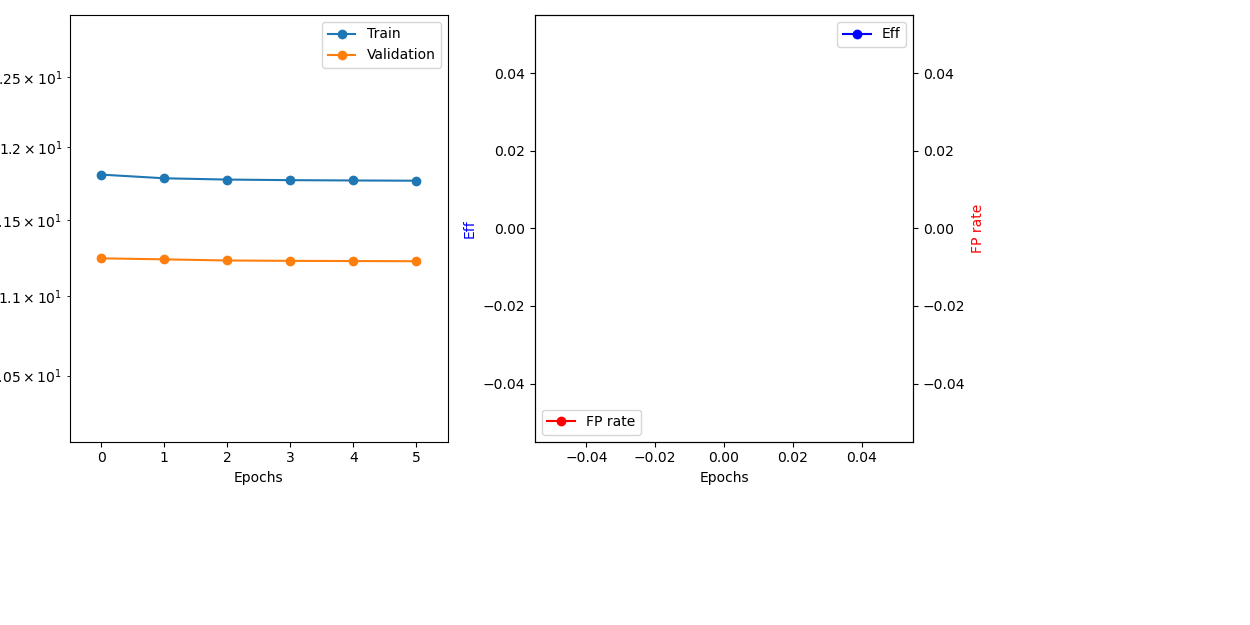

In [8]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

### Train the model

In [ ]:
# save initial model state
param_states.append(get_param_state(model))
torch.save(model.state_dict(), output / f'{name}_init.pyt')

for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start = len(results),
                        notebook = True,
                        ep_optimizer = ep_optimizer,
                        lr_scheduler = lr_scheduler,
                        careful = careful,
                        adaptive = adaptive
                      ):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')
    #mine
    param_states.append(get_param_state(model))
    
# save final model and stats
torch.save(model.state_dict(), output / f'{name}_final.pyt')
results.to_hdf(f'{name}_stats.hdf5', 'results')

Number of batches: train = 5000, val = 1250


Number of batches: train = 5000, val = 1250


Epoch 0: train=11.8074, val=11.2442, took 388.87 s


Epoch 1: train=11.7821, val=11.2375, took 766.76 s


Epoch 2: train=11.7732, val=11.2301, took 750.68 s


Epoch 3: train=11.7692, val=11.2276, took 624.67 s


Epoch 4: train=11.767, val=11.2264, took 735.67 s


Epoch 5: train=11.7653, val=11.2253, took 743.66 s


Save the plot above:

In [ ]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

### Plotting the angle grid, and the model outputs

In [ ]:
from functions.utils import state_dict_to_vector
def angle_between(a, b):
    return np.arccos(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))

angle_grids = []
grid_size = 30
num_epochs = n_epochs

ep_intervals = [(np.arange(0, num_epochs+1, grid_size)[i], np.arange(0, num_epochs+1, grid_size)[i+1]) for i in range(len(np.arange(0, num_epochs+1, grid_size))-1)]

for interval in ep_intervals:
    
    these_param_states = []
    for i in range(interval[0], interval[1]):
        these_param_states.append(param_states[i])
        #print("Loaded", file_names[i])
        
    interval_size = len(these_param_states)-1    
    these_steps = [these_param_states[i+1]-these_param_states[i] for i in range(interval_size)]
    
    this_angle_grid = np.zeros((interval_size, interval_size))
    
    for i in range(interval_size):
        for j in range(i+1, interval_size):#range(i+1, interval_size):
            angle = angle_between(these_steps[i], these_steps[j])
            this_angle_grid[i,j] = angle
            this_angle_grid[j,i] = angle
            
    angle_grids.append(this_angle_grid)

In [ ]:
import matplotlib.colors as colors
import matplotlib.cm as cm

for angle_grid in angle_grids:
    plt.figure(figsize=(12,8))
    norm = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))   
    plt.imshow(angle_grid, cmap=cm.jet)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet))
    plt.xlabel('Step i')
    plt.ylabel('Step j')
    
#print("num params:", len(these_param_states[0]))

In [ ]:
state_dicts = []
for i in np.arange(0, num_epochs, 1):
    state_dicts.append( (i, vector_to_state_dict(param_states[i], model)) )

data = load_data()

In [ ]:
plot_DDplus_hists(state_dicts, data)